# Testing phase transition -- periodic Ring lattice

## Tome & Oliveira dynamics

### generating command lines

In [82]:
import numpy

#cmd_to_generate = ['par','seq']
cmd_to_generate = ['seq']

cmd_line_seq = 'contact_process.py -l {lmbda:g} -N {N:d} -tTrans {tTrans:d} -tTotal {tTotal:d} -graph ring -X0 1 -fX0 0.1 -sim timeevo -outputFile {out_dir:s}/N{N:d}/corr_ring/cp_ring_N{N:d}_l{lmbda:g}_seq_timeevo.mat -update sequential -iterdynamics tome_oliveira'
cmd_line_par = 'contact_process.py -l {lmbda:g} -N {N:d} -tTrans {tTrans:d} -tTotal {tTotal:d} -graph ring -X0 1 -fX0 0.0 -sim aval -outputFile {out_dir:s}/N{N:d}/corr_ring/cp_ring_N{N:d}_l{lmbda:g}_par_aval.mat -update parallel -iterdynamics tome_oliveira'

N_values     = [100,500,1000,2560,5000]
tTrans       = 10000
tTotal       = 30000
#lmbda_values = numpy.linspace(1.0,4.5,100)
lmbda_values_seq = numpy.linspace(3.0,3.6,1000) # lmbda_values
lmbda_values_par = numpy.linspace(2.3,2.9,1000) # lmbda_values

cmd_line_filename = f'lines_to_run_CP_phasetrans_ring_TO.sh'
out_dir           =  'test_sim/phase_trans_TO'


with open(cmd_line_filename,'w') as f:
    for N in N_values:
        if 'seq' in cmd_to_generate:
            for l in lmbda_values_seq:
                f.write(cmd_line_seq.format(lmbda=l,N=N,tTrans=2*tTrans*N,tTotal=tTotal*N,out_dir=out_dir) + '\n')
            f.write('\n')
        if 'par' in cmd_to_generate:
            for l in lmbda_values_par:
                f.write(cmd_line_par.format(lmbda=l,N=N,tTrans=tTrans,tTotal=tTotal,out_dir=out_dir) + '\n')
            f.write('\n')
        f.write('\n')

### Original dynamics (wrong critical point)


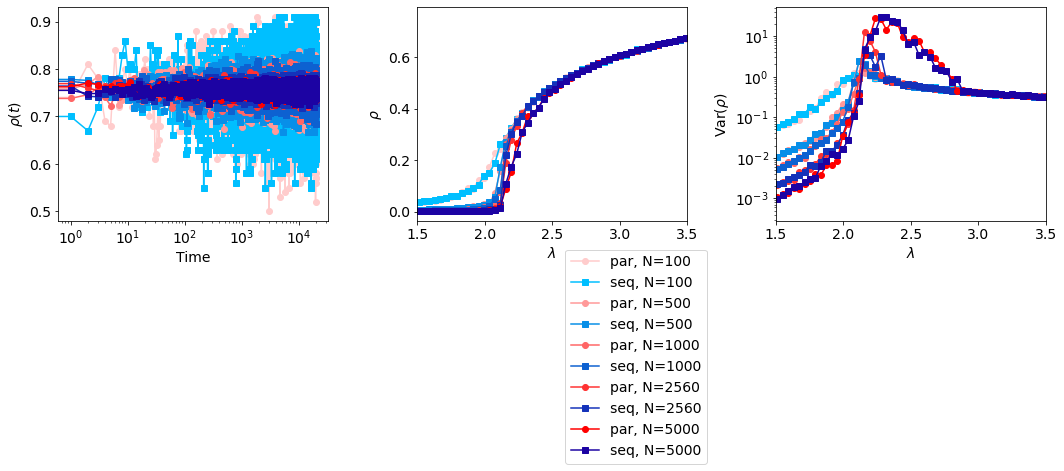

In [28]:
import os
import glob
import numpy
import matplotlib.pyplot as plt
import modules.io as io


import sys
del sys.modules['modules.plot_func']
del pltt
import modules.plot_func as pltt


input_dir = ['test_sim/phase_trans_TO_old/N100/corr_ring',
             'test_sim/phase_trans_TO_old/N500/corr_ring',
             'test_sim/phase_trans_TO_old/N1000/corr_ring',
             'test_sim/phase_trans_TO_old/N2560/corr_ring',
             'test_sim/phase_trans_TO_old/N5000/corr_ring']

pt_par = [ sorted([ io.import_mat_file(f) for f in glob.glob(os.path.join(inpd,'*_par_*.mat'))], key=lambda dd:dd.l) for inpd in input_dir ]
pt_seq = [ sorted([ io.import_mat_file(f) for f in glob.glob(os.path.join(inpd,'*_seq_*.mat'))], key=lambda dd:dd.l) for inpd in input_dir ]


N_values     = numpy.array([ dd[0].N for dd in pt_par ])

l_values_par = [ numpy.array([            dd.l                     for dd in dN ]) for dN in pt_par ]
rho_par      = [ numpy.array([ numpy.nanmean(dd.rho)               for dd in dN ]) for dN in pt_par ]
rho_var_par  = [ numpy.array([ float(dd.N) * numpy.nanvar( dd.rho) for dd in dN ]) for dN in pt_par ]

l_values_seq = [ numpy.array([            dd.l                     for dd in dN ]) for dN in pt_seq ]
rho_seq      = [ numpy.array([ numpy.nanmean(dd.rho)               for dd in dN ]) for dN in pt_seq ]
rho_var_seq  = [ numpy.array([ float(dd.N) * numpy.nanvar( dd.rho) for dd in dN ]) for dN in pt_seq ]



#colors = plt.get_cmap('cividis')(numpy.linspace(0,1,N_values.size))
colors_seq = pltt.cmap_blue_deep()(numpy.linspace(0,1,N_values.size))
colors_par = pltt.cmap_red_standard()(numpy.linspace(0,1,N_values.size))

plt.rcParams.update({'font.size':14})
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,4))

ax[2].sharex(ax[1])

for k,N in enumerate(N_values):
    ax[0].plot(pt_par[k][-1].time                 ,pt_par[k][-1].rho,'-o',label=f'par, N={N}',color=colors_par[k])
    ax[0].plot(pt_seq[k][-1].time/pt_seq[k][-1].dt,pt_seq[k][-1].rho,'-s',label=f'seq, N={N}',color=colors_seq[k])
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('$\\rho(t)$')
    ax[0].set_xscale('log')
    ax[1].plot(l_values_par[k],rho_par[k],'-o',label=f'par, N={N}',color=colors_par[k])
    ax[1].plot(l_values_seq[k],rho_seq[k],'-s',label=f'seq, N={N}',color=colors_seq[k])
    ax[1].set_xlabel('$\\lambda$')
    ax[1].set_ylabel('$\\rho$')
    ax[2].plot(l_values_par[k],rho_var_par[k],'-o',label=f'par, N={N}',color=colors_par[k])
    ax[2].plot(l_values_seq[k],rho_var_seq[k],'-s',label=f'seq, N={N}',color=colors_seq[k])
    ax[2].set_xlabel('$\\lambda$')
    ax[2].set_ylabel('Var($\\rho$)')
    ax[2].set_yscale('log')

ax[1].set_xlim((1.5,3.5))

plt.tight_layout()

ax[1].legend(bbox_to_anchor=(1.1,-0.1), loc='upper right')

plt.show()

### Modified dynamics (correct critical point)

#### loading data (~15 min for coarse data... 150 min for coarse + fine data)

In [1]:
import os
import sys
import glob
import numpy
import scipy.io
import matplotlib.pyplot as plt
import modules.phasetransdata as ptd
import modules.misc_func as misc
import modules.io as io
if ptd:
    del sys.modules['modules.phasetransdata']
    del ptd
import modules.phasetransdata as ptd

#data_to_plot = ['seq','par']
data_to_plot = ['par','seq']

base_dir  = 'test_sim/phase_trans_TO'

input_dir = [os.path.join(base_dir, subdir) for subdir in 
                ('N100/corr_ring',
                 'N500/corr_ring',
                 'N1000/corr_ring',
                 'N2560/corr_ring',
                 'N5000/corr_ring')]

lmbda_values_broad     = numpy.linspace(1.0,4.5,100)
lmbda_values_fine_seq  = numpy.linspace(3.0,3.6,1000) # lmbda_values
lmbda_values_fine_par  = numpy.linspace(2.3,2.9,1000) # lmbda_values

load_phasetrans_data         = True
save_phasetrans_data         = True
return_file_data             = False
calc_suscept_bootstrap_error = True
n_time_points_for_mean       = 1000

N_values                     = numpy.array(misc.get_par_value_from_str(input_dir,'N',int)) #numpy.array([ dd[0].N for dd in d_par ])

if load_phasetrans_data:
    _       ,pt_par_TO,d_par_TO = ptd.load_phasetrans_file(os.path.join(base_dir,'phasetrans_ring_coarse_par.mat'))
    N_values,pt_seq_TO,d_seq_TO = ptd.load_phasetrans_file(os.path.join(base_dir,'phasetrans_ring_merged_seq.mat'))
else:
    if 'par' in data_to_plot:
        f_list_broad_par_iter = ([f for f in glob.glob(os.path.join(inpd,'*_par_*.mat')) if misc.par_value_in_str(f,'l',lmbda_values_broad,float,'{:g}')]  for inpd   in input_dir) # creating iterator that generates file lists
        pt_par_TO,d_par_TO    = misc.unpack_list_of_tuples([ ptd.calc_phasetrans_params_struct(f_list,'l',time_k1=10000,time_k2=10000,return_file_data=return_file_data,calc_suscept_bootstrap_error=calc_suscept_bootstrap_error) for f_list in f_list_broad_par_iter ])
        if save_phasetrans_data:
            ptd.save_phasetrans_file(os.path.join(base_dir,'phasetrans_ring_coarse_par.mat'),N_values,pt_par_TO,d_par_TO)
    if 'seq' in data_to_plot:
        f_list_broad_seq_iter        = ([f for f in glob.glob(os.path.join(inpd,'*_seq_*.mat')) if misc.par_value_in_str(f,'l',lmbda_values_broad   ,float,'{:g}')]  for inpd   in input_dir) # creating iterator that generates file lists
        f_list_fine_seq_iter         = ([f for f in glob.glob(os.path.join(inpd,'*_seq_*.mat')) if misc.par_value_in_str(f,'l',lmbda_values_fine_seq,float,'{:g}')]  for inpd   in input_dir) # creating iterator that generates file lists
        pt_seq_TO     ,d_seq_TO      = misc.unpack_list_of_tuples([ ptd.calc_phasetrans_params_struct(f_list,'l',time_k1=10000,time_k2=10000,n_time_points=N*n_time_points_for_mean,return_file_data=return_file_data,calc_suscept_bootstrap_error=calc_suscept_bootstrap_error) for f_list,N in zip(f_list_broad_seq_iter, N_values) ])
        pt_fine_seq_TO,d_fine_seq_TO = misc.unpack_list_of_tuples([ ptd.calc_phasetrans_params_struct(f_list,'l',time_k1=10000,time_k2=10000,n_time_points=N*n_time_points_for_mean,return_file_data=return_file_data,calc_suscept_bootstrap_error=calc_suscept_bootstrap_error) for f_list,N in zip(f_list_fine_seq_iter , N_values) ])
        pt_seq_TO                    = ptd.merge_phasetrans_params_struct(pt_seq_TO,pt_fine_seq_TO,'l')
        if save_phasetrans_data:
            ptd.save_phasetrans_file(os.path.join(base_dir,'phasetrans_ring_merged_seq.mat'),N_values,pt_seq_TO,d_seq_TO)


#### plotting figures

* maximum of susceptibility:
lambda_max_seq(N) =  [3.31231 3.31532 3.32252 3.34294 3.32913]

* selected values for Finite-Size Scaling:
lambda_seq =  [2.48485 3.      3.2     4.00505 4.5    ]


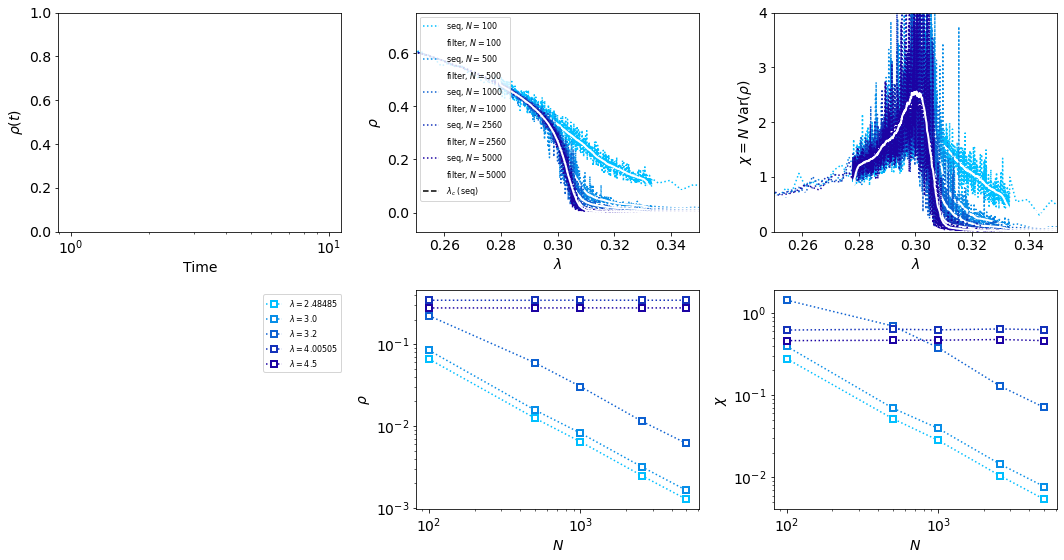

In [38]:
#colors = plt.get_cmap('cividis')(numpy.linspace(0,1,N_values.size))
import sys
import modules.plot_func as pltt
if pltt:
    del sys.modules['modules.plot_func']
    del pltt
import modules.plot_func as pltt
import modules.correlation as corr
import modules.phasetransdata as ptd

data_to_plot        = ['seq']
use_filter_suscept  = True


# filtering curves of rho and suscept
filter_func     = corr.moving_average # corr.scipy.signal.wiener    
filter_args     = dict(n=100)          # dict(mysize=300, noise=None)   # for moving average
pt_seq_TO_flt   = [ misc.structtype(l=pt.l,rho=filter_func(pt.rho,**filter_args),suscept=filter_func(pt.suscept,**filter_args)) for pt in pt_seq_TO ]

# getting max of susceptibility
get_suscept_max = filter_func if use_filter_suscept else lambda x,**args: x
l_max_vs_N_par  = numpy.array([ dd.l[numpy.nanargmax(get_suscept_max(dd.suscept,**filter_args))] for dd in pt_par_TO ])
l_max_vs_N_seq  = numpy.array([ dd.l[numpy.nanargmax(get_suscept_max(dd.suscept,**filter_args))] for dd in pt_seq_TO ])

# assuming simulations for all N have the same l values
l_c_seq     = 3.297848
dk          = 30
l_c_app_par = l_max_vs_N_par[-2]
l_c_app_seq = 3.2#l_c_seq#l_max_vs_N_seq[-1]
l_probe_par = numpy.array([1.5, 2.0, l_c_app_par, 3.0, 3.5])
l_probe_seq = numpy.array([2.5, 3.0, l_c_app_seq, 4.0, 4.5])
l_selected_par,l_selected_ind_par = misc.find_closest_value(pt_par_TO[0].l,l_probe_par, return_all=True)
l_selected_seq,l_selected_ind_seq = misc.find_closest_value(pt_seq_TO[0].l,l_probe_seq, return_all=True)
#l_selected_par,l_selected_ind_par = pt_par_TO[0].l[((k:=misc.find_closest_value(pt_par_TO[0].l,l_c_app_par))-dk):(k+dk)],numpy.arange(pt_par_TO[0].l.size)[(k-dk):(k+dk)]
#l_selected_seq,l_selected_ind_seq = pt_seq_TO[0].l[((k:=misc.find_closest_value(pt_seq_TO[0].l,l_c_app_seq))-dk):(k+dk)],numpy.arange(pt_seq_TO[0].l.size)[(k-dk):(k+dk)]

# generating matrices rho[l,N] suscept[l,N]
if 'par' in data_to_plot:
    rho_l_N_par     = numpy.array([pt.rho[l_selected_ind_par]     for pt in pt_par_TO]).T
    suscept_l_N_par = numpy.array([pt.suscept[l_selected_ind_par] for pt in pt_par_TO]).T
if 'seq' in data_to_plot:
    rho_l_N_seq     = numpy.array([pt.rho[l_selected_ind_seq]     for pt in pt_seq_TO_flt]).T
    suscept_l_N_seq = numpy.array([pt.suscept[l_selected_ind_seq] for pt in pt_seq_TO_flt]).T

print('* maximum of susceptibility:')
print('lambda_max_par(N) = ',l_max_vs_N_par) if 'par' in data_to_plot else None
print('lambda_max_seq(N) = ',l_max_vs_N_seq) if 'seq' in data_to_plot else None
print('')
print('* selected values for Finite-Size Scaling:')
print('lambda_par = ',l_selected_par) if 'par' in data_to_plot else None
print('lambda_seq = ',l_selected_seq) if 'seq' in data_to_plot else None


colors_par     = pltt.cmap_red_standard()(numpy.linspace(0,1,N_values.size))
colors_seq     = pltt.cmap_blue_deep()(   numpy.linspace(0,1,N_values.size))
colors_par_FSS = pltt.cmap_red_standard()(numpy.linspace(0,1,l_selected_par.size))
colors_seq_FSS = pltt.cmap_blue_deep()(   numpy.linspace(0,1,l_selected_seq.size))

plt.rcParams.update({'font.size':14})
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(15,8))

ax[0,2].sharex(ax[0,1])
ax[1,0].set_visible(False)

# which lambda to show time series for
ind = -1

for k,N in enumerate(N_values):
    if 'par' in data_to_plot:
        if len(d_par_TO[k]):
            ax[0,0].plot(d_par_TO[k][ind].time , d_par_TO[k][ind].rho ,'-' ,label=f'par, $N={N}$',color=colors_par[k])
        ax[0,1].plot(     pt_par_TO[k].l       , pt_par_TO[k].rho     ,':o',label=f'par, $N={N}$',color=colors_par[k])
        ax[0,2].plot(     pt_par_TO[k].l       , pt_par_TO[k].suscept ,':o',label=f'par, $N={N}$',color=colors_par[k])
    if 'seq' in data_to_plot:
        if len(d_seq_TO[k]):
            ax[0,0].plot(d_seq_TO[k][ind].time/d_seq_TO[k][ind].N , d_seq_TO[k][ind].rho     ,'-' ,label=f'seq, $N={N}$',color=colors_seq[k])
        ax[0,1].plot(    1/pt_seq_TO[k].l                           , pt_seq_TO[k].rho         ,':',label=f'seq, $N={N}$',color=colors_seq[k])
        ax[0,2].plot(    1/pt_seq_TO[k].l                           , pt_seq_TO[k].suscept     ,':',label=f'seq, $N={N}$',color=colors_seq[k])
        ax[0,1].plot(    1/pt_seq_TO_flt[k].l                       , pt_seq_TO_flt[k].rho     ,'-' ,label=f'filter, $N={N}$',color='w',linewidth=2)
        ax[0,2].plot(    1/pt_seq_TO_flt[k].l                       , pt_seq_TO_flt[k].suscept ,'-' ,label=f'filter, $N={N}$',color='w',linewidth=2)
    ax[0,0].set_xlabel('Time')
    ax[0,0].set_ylabel('$\\rho(t)$')
    ax[0,0].set_xscale('log')
    #ax[0,0].set_yscale('log')
    ax[0,1].set_xlabel('$\\lambda$')
    ax[0,1].set_ylabel('$\\rho$')
    ax[0,2].set_xlabel('$\\lambda$')
    ax[0,2].set_ylabel('$\chi=N$ Var($\\rho$)')
    #ax[0,2].set_yscale('log')

ax[0,1].set_xlim((0.25,0.35))
#ax[0,1].set_xlim((1.5,4.0))
#ax[0,1].set_xlim((3.0,3.6))
#ax[0,2].set_ylim((5e-3,1e1))
ax[0,2].set_ylim((0,4))

ax[0,1].vlines(l_c_seq,ymin=ax[0,1].get_ylim()[0],ymax=ax[0,1].get_ylim()[1],ls='--',color='k',label='$\\lambda_c$ (seq)')
ax[0,2].vlines(l_c_seq,ymin=ax[0,2].get_ylim()[0],ymax=ax[0,2].get_ylim()[1],ls='--',color='k',label='$\\lambda_c$ (seq)')

if 'par' in data_to_plot:
    for k,l in enumerate(l_selected_par):
        ax[1,1].errorbar(N_values,rho_l_N_par[k]    ,':o',label=f'$\\lambda={l}$',color=colors_par_FSS[k],markerfacecolor='w',markeredgewidth=2)
        ax[1,2].errorbar(N_values,suscept_l_N_par[k],':o',label=f'$\\lambda={l}$',color=colors_par_FSS[k],markerfacecolor='w',markeredgewidth=2)
if 'seq' in data_to_plot:
    for k,l in enumerate(l_selected_seq):
        ax[1,1].plot(N_values,rho_l_N_seq[k]    ,':s',label=f'$\\lambda={l}$',color=colors_seq_FSS[k],markerfacecolor='w',markeredgewidth=2)
        ax[1,2].plot(N_values,suscept_l_N_seq[k],':s',label=f'$\\lambda={l}$',color=colors_seq_FSS[k],markerfacecolor='w',markeredgewidth=2)

ax[1,1].set_xlabel('$N$')
ax[1,1].set_ylabel('$\\rho$')
ax[1,2].set_xlabel('$N$')
ax[1,2].set_ylabel('$\\chi$')
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,2].set_xscale('log')
ax[1,2].set_yscale('log')

plt.tight_layout()
ax[0,1].legend(bbox_to_anchor=( 0.00,1.0), loc='upper left' , fontsize=8)
ax[1,1].legend(bbox_to_anchor=(-0.25,1.0), loc='upper right', fontsize=8)

plt.show()


## Marro & Dickman dynamics

### generating command lines

In [7]:
import numpy

#cmd_to_generate = ['par','seq']
cmd_to_generate = ['seq']

cmd_line_seq = 'contact_process.py -l {lmbda:g} -N {N:d} -tTrans {tTrans:d} -tTotal {tTotal:d} -graph ring -X0 1 -fX0 0.1 -sim timeevo -outputFile {out_dir:s}/N{N:d}/corr_ring/cp_ring_N{N:d}_l{lmbda:g}_seq_timeevo.mat -update sequential -iterdynamics marro_dickman'
cmd_line_par = 'contact_process.py -l {lmbda:g} -N {N:d} -tTrans {tTrans:d} -tTotal {tTotal:d} -graph ring -X0 1 -fX0 0.0 -sim aval -outputFile {out_dir:s}/N{N:d}/corr_ring/cp_ring_N{N:d}_l{lmbda:g}_par_aval.mat -update parallel -iterdynamics marro_dickman'

N_values = [100,500,1000,2560,5000]
tTrans   = 10000
tTotal   = 30000

cmd_line_filename = f'lines_to_run_CP_phasetrans_ring_MD.sh'
out_dir           =  'test_sim/phase_trans_MD'

lmbda_values = numpy.linspace(1.0,4.5,100)

with open(cmd_line_filename,'w') as f:
    for N in N_values:
        if 'seq' in cmd_to_generate:
            for l in lmbda_values:
                f.write(cmd_line_seq.format(lmbda=l,N=N,tTrans=2*tTrans*N,tTotal=tTotal*N,out_dir=out_dir) + '\n')
            f.write('\n')
        if 'par' in cmd_to_generate:
            for l in lmbda_values:
                f.write(cmd_line_par.format(lmbda=l,N=N,tTrans=tTrans,tTotal=tTotal,out_dir=out_dir) + '\n')
            f.write('\n')
        f.write('\n')

### Original dynamics

#### loading data (~15 min)

In [ ]:
import os
import glob
import numpy
import matplotlib.pyplot as plt
import modules.phasetransdata as ptd
import modules.misc_func as misc

data_to_plot = ['seq','par']
#data_to_plot = ['par']

input_dir = ['test_sim/phase_trans_MD/N100/corr_ring',
             'test_sim/phase_trans_MD/N500/corr_ring',
             'test_sim/phase_trans_MD/N1000/corr_ring',
             'test_sim/phase_trans_MD/N2560/corr_ring',
             'test_sim/phase_trans_MD/N5000/corr_ring']

if 'par' in data_to_plot:
    pt_par_MD,d_par_MD = misc.unpack_list_of_tuples([ ptd.calc_phasetrans_params_struct(glob.glob(os.path.join(inpd,'*_par_*.mat')),'l',time_k1=10000,time_k2=10000,return_file_data=True,calc_suscept_bootstrap_error=True) for inpd in input_dir ])
if 'seq' in data_to_plot:
    pt_seq_MD,d_seq_MD = misc.unpack_list_of_tuples([ ptd.calc_phasetrans_params_struct(glob.glob(os.path.join(inpd,'*_seq_*.mat')),'l',time_k1=10000,time_k2=10000,return_file_data=True,calc_suscept_bootstrap_error=True) for inpd in input_dir ])


N_values     = numpy.array(misc.get_par_value_from_str(input_dir,'N')) #numpy.array([ dd[0].N for dd in d_par ])


#### plotting figures

* maximum of susceptibility:
lambda_max(N) =  [2.62626 2.59091 2.62626 2.66162 2.87374]
lambda_max(N) =  [3.43939 3.33333 3.33333 3.33333 3.40404]

* selected values for Finite-Size Scaling:
lambda =  [1.49495 1.9899  2.66162 3.01515 3.5101 ]
lambda =  [2.48485 3.01515 3.40404 4.00505 4.5    ]


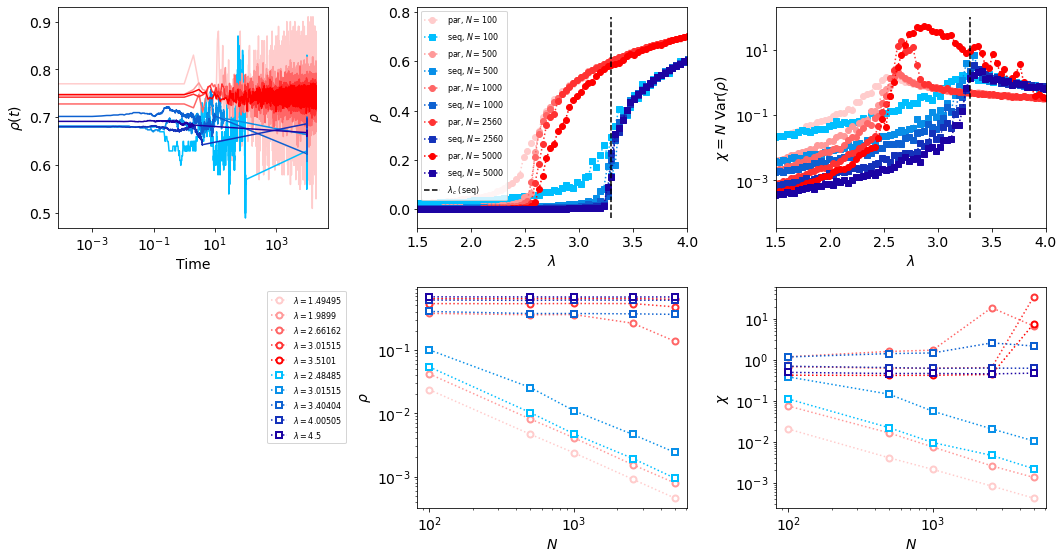

In [ ]:
#colors = plt.get_cmap('cividis')(numpy.linspace(0,1,N_values.size))
#import sys
#del sys.modules['modules.plot_func']
#del pltt
import modules.plot_func as pltt
import modules.correlation as corr
import modules.phasetransdata as ptd

use_filter_suscept = False

get_suscept_max    = corr.moving_average if use_filter_suscept else lambda x,n:x
l_max_vs_N_par = numpy.array([ dd.l[numpy.nanargmax(get_suscept_max(dd.suscept,n=20))] for dd in pt_par_MD ])
l_max_vs_N_seq = numpy.array([ dd.l[numpy.nanargmax(get_suscept_max(dd.suscept,n=20))] for dd in pt_seq_MD ])

# assuming simulations for all N have the same l values
l_c_seq   = 3.297848
sel_N_par = -2 # index to select from the maximum of the susceptibility curve lambda_max(N)
sel_N_seq = -1 # index to select from the maximum of the susceptibility curve lambda_max(N)
l_selected_par,l_selected_ind_par = misc.find_closest_value(pt_par_MD[0].l,numpy.array([1.5, 2.0, l_max_vs_N_par[sel_N_par], 3.0, 3.5]), return_all=True)
l_selected_seq,l_selected_ind_seq = misc.find_closest_value(pt_seq_MD[0].l,numpy.array([2.5, 3.0, l_max_vs_N_seq[sel_N_seq], 4.0, 4.5]), return_all=True)
#l_selected_seq,l_selected_ind_seq = ptd.find_closest_value(pt_seq_TO[0].l,numpy.array([2.5, 3.0, l_c_seq, 4.0, 4.5]), return_all=True)

# generating matrices rho[l,N] suscept[l,N]
rho_l_N_par     = numpy.array([pt.rho[l_selected_ind_par] for pt in pt_par_MD]).T
rho_l_N_seq     = numpy.array([pt.rho[l_selected_ind_seq] for pt in pt_seq_MD]).T
suscept_l_N_par = numpy.array([pt.suscept[l_selected_ind_par] for pt in pt_par_MD]).T
suscept_l_N_seq = numpy.array([pt.suscept[l_selected_ind_seq] for pt in pt_seq_MD]).T

print('* maximum of susceptibility:')
print('lambda_max(N) = ',l_max_vs_N_par)
print('lambda_max(N) = ',l_max_vs_N_seq)
print('')
print('* selected values for Finite-Size Scaling:')
print('lambda = ',l_selected_par)
print('lambda = ',l_selected_seq)





colors_par     = pltt.cmap_red_standard()(numpy.linspace(0,1,N_values.size))
colors_seq     = pltt.cmap_blue_deep()(   numpy.linspace(0,1,N_values.size))
colors_par_FSS = pltt.cmap_red_standard()(numpy.linspace(0,1,l_selected_par.size))
colors_seq_FSS = pltt.cmap_blue_deep()(   numpy.linspace(0,1,l_selected_seq.size))

plt.rcParams.update({'font.size':14})
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(15,8))

ax[0,2].sharex(ax[0,1])
ax[1,0].set_visible(False)

# which lambda to show time series for
ind = -1

for k,N in enumerate(N_values):
    if 'par' in data_to_plot:
        if len(d_par_MD):
            ax[0,0].plot(d_par_MD[k][ind].time , d_par_MD[k][ind].rho ,'-' ,label=f'par, $N={N}$',color=colors_par[k])
        ax[0,1].plot(     pt_par_MD[k].l       , pt_par_MD[k].rho     ,':o',label=f'par, $N={N}$',color=colors_par[k])
        ax[0,2].plot(     pt_par_MD[k].l       , pt_par_MD[k].suscept ,':o',label=f'par, $N={N}$',color=colors_par[k])
    if 'seq' in data_to_plot:
        if len(d_seq_MD):
            ax[0,0].plot(d_seq_MD[k][ind].time/d_seq_MD[k][ind].N , d_seq_MD[k][ind].rho ,'-' ,label=f'seq, $N={N}$',color=colors_seq[k])
        ax[0,1].plot(    pt_seq_MD[k].l                           , pt_seq_MD[k].rho     ,':s',label=f'seq, $N={N}$',color=colors_seq[k])
        ax[0,2].plot(    pt_seq_MD[k].l                           , pt_seq_MD[k].suscept ,':s',label=f'seq, $N={N}$',color=colors_seq[k])
    ax[0,0].set_xlabel('Time')
    ax[0,0].set_ylabel('$\\rho(t)$')
    ax[0,0].set_xscale('log')
    #ax[0,0].set_yscale('log')
    ax[0,1].set_xlabel('$\\lambda$')
    ax[0,1].set_ylabel('$\\rho$')
    ax[0,2].set_xlabel('$\\lambda$')
    ax[0,2].set_ylabel('$\chi=N$ Var($\\rho$)')
    ax[0,2].set_yscale('log')

ax[0,1].set_xlim((1.5,4.0))

ax[0,1].vlines(l_c_seq,ymin=ax[0,1].get_ylim()[0],ymax=ax[0,1].get_ylim()[1],ls='--',color='k',label='$\\lambda_c$ (seq)')
ax[0,2].vlines(l_c_seq,ymin=ax[0,2].get_ylim()[0],ymax=ax[0,2].get_ylim()[1],ls='--',color='k',label='$\\lambda_c$ (seq)')

if 'par' in data_to_plot:
    for k,l in enumerate(l_selected_par):
        ax[1,1].plot(N_values,rho_l_N_par[k]    ,':o',label=f'$\\lambda={l}$',color=colors_par_FSS[k],markerfacecolor='w',markeredgewidth=2)
        ax[1,2].plot(N_values,suscept_l_N_par[k],':o',label=f'$\\lambda={l}$',color=colors_par_FSS[k],markerfacecolor='w',markeredgewidth=2)
if 'seq' in data_to_plot:
    for k,l in enumerate(l_selected_seq):
        ax[1,1].plot(N_values,rho_l_N_seq[k]    ,':s',label=f'$\\lambda={l}$',color=colors_seq_FSS[k],markerfacecolor='w',markeredgewidth=2)
        ax[1,2].plot(N_values,suscept_l_N_seq[k],':s',label=f'$\\lambda={l}$',color=colors_seq_FSS[k],markerfacecolor='w',markeredgewidth=2)

ax[1,1].set_xlabel('$N$')
ax[1,1].set_ylabel('$\\rho$')
ax[1,2].set_xlabel('$N$')
ax[1,2].set_ylabel('$\\chi$')
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,2].set_xscale('log')
ax[1,2].set_yscale('log')

plt.tight_layout()
ax[0,1].legend(bbox_to_anchor=( 0.00,1.0), loc='upper left' , fontsize=8)
ax[1,1].legend(bbox_to_anchor=(-0.25,1.0), loc='upper right', fontsize=8)

plt.show()
